This demo tries to generate ephys data from single-compartment model

In [1]:
import numpy as np
from scipy.integrate import ode
import matplotlib.pyplot as plt
from Units import *
from tqdm import tqdm

from Parameters_4 import *
from PC_four_channel import *

from scipy.io import savemat

## Simulation

In [2]:
# set model params
t_run=0.45
cs_duration=100*ms
cs_times = [400*ms]

cf_current_value = 100
# set the cf input
cf_a=[cf_current_value*uA]*len(cs_times)

# run the model
i_e=Electrode(cs_times,cs_duration,cf_a)

somatic_voltage=Somatic_voltage(c_soma,g_rna,g_k,g_sk,g_ca,g_leak,e_na,e_k,e_ca,e_leak,i_e,v_initial)
f=All_derivatives(somatic_voltage,rna_states,rate_k,rate_sk,rate_ca,rate_ca_concentration)
rna_y_initial=[rna_states.c1_initial,rna_states.c2_initial,0,0,0,0,0,0,0,0,0,0,0]
y_initial=[somatic_voltage.v_initial,0]+rna_y_initial+[0,0,baseline_calcium_concentration]

t0=0
t1=t_run

integrator = ode(f).set_integrator('vode', method='bdf', with_jacobian=False)
integrator.set_initial_value(y_initial, t0)

norm_n=10
print_n=2

norm_c=1
print_c=1

time_base = []
voltage_trace = []
k_n_trace = []
rna_o_trace = []
sk_w_trace = []
ca_m_trace = []
ca_concentration_trace = []

while integrator.successful() and integrator.t < t1:

    integrator.integrate(integrator.t+dt)

    if norm_c==1:
        y=integrator.y
        y=normalize(y)
        integrator.set_initial_value(y,integrator.t)
        norm_c=norm_n

    if print_c==1:
        print_c=print_n
        time_base.append(integrator.t)
        
        # v_soma=y[0]
        # k_n   =y[1]
        # rna_y =y[2:15]
        # rna_o =y[7]
        # sk_w=y[15]
        # ca_m=y[16]
        # ca_concentration=y[17]
        voltage_trace.append(integrator.y[0])
        k_n_trace.append(integrator.y[1])
        rna_o_trace.append(integrator.y[7])
        sk_w_trace.append(integrator.y[15])
        ca_m_trace.append(integrator.y[16])
        ca_concentration_trace.append(integrator.y[17])

    norm_c-=1
    print_c-=1

time_base = np.array(time_base)
voltage_trace = np.array(voltage_trace)
k_n_trace = np.array(k_n_trace)
rna_o_trace = np.array(rna_o_trace)
sk_w_trace = np.array(sk_w_trace)
ca_m_trace = np.array(ca_m_trace)
ca_concentration_trace = np.array(ca_concentration_trace)


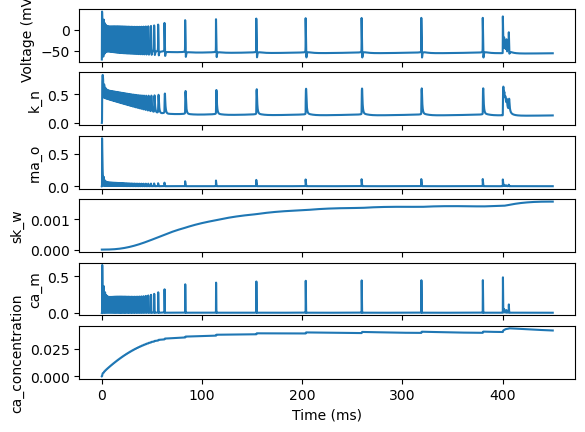

Text(0, 0.5, 'Voltage (mV)')

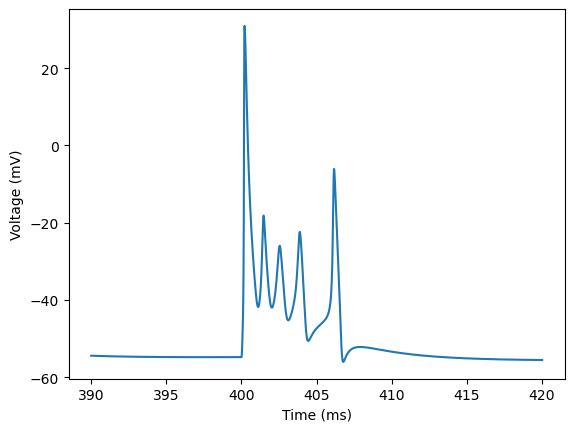

In [3]:
# plot the soma membrane voltage
plt.figure()

plt.subplot(611)
plt.plot(time_base*1000,voltage_trace*1000)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')

plt.subplot(612)
plt.plot(time_base*1000,k_n_trace)
plt.xlabel('Time (ms)')
plt.ylabel('k_n')

plt.subplot(613)
plt.plot(time_base*1000,rna_o_trace)
plt.xlabel('Time (ms)')
plt.ylabel('rna_o')

plt.subplot(614)
plt.plot(time_base*1000,sk_w_trace)
plt.xlabel('Time (ms)')
plt.ylabel('sk_w')

plt.subplot(615)
plt.plot(time_base*1000,ca_m_trace)
plt.xlabel('Time (ms)')
plt.ylabel('ca_m')

plt.subplot(616)
plt.plot(time_base*1000,ca_concentration_trace)
plt.xlabel('Time (ms)')
plt.ylabel('ca_concentration')

plt.show()

plt.figure()
plt.plot(time_base[(time_base>0.39)*(time_base<0.42)]*1000,voltage_trace[(time_base>0.39)*(time_base<0.42)]*1000)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')

Assuming point source and ephys is only scale version of soma transmembrane current

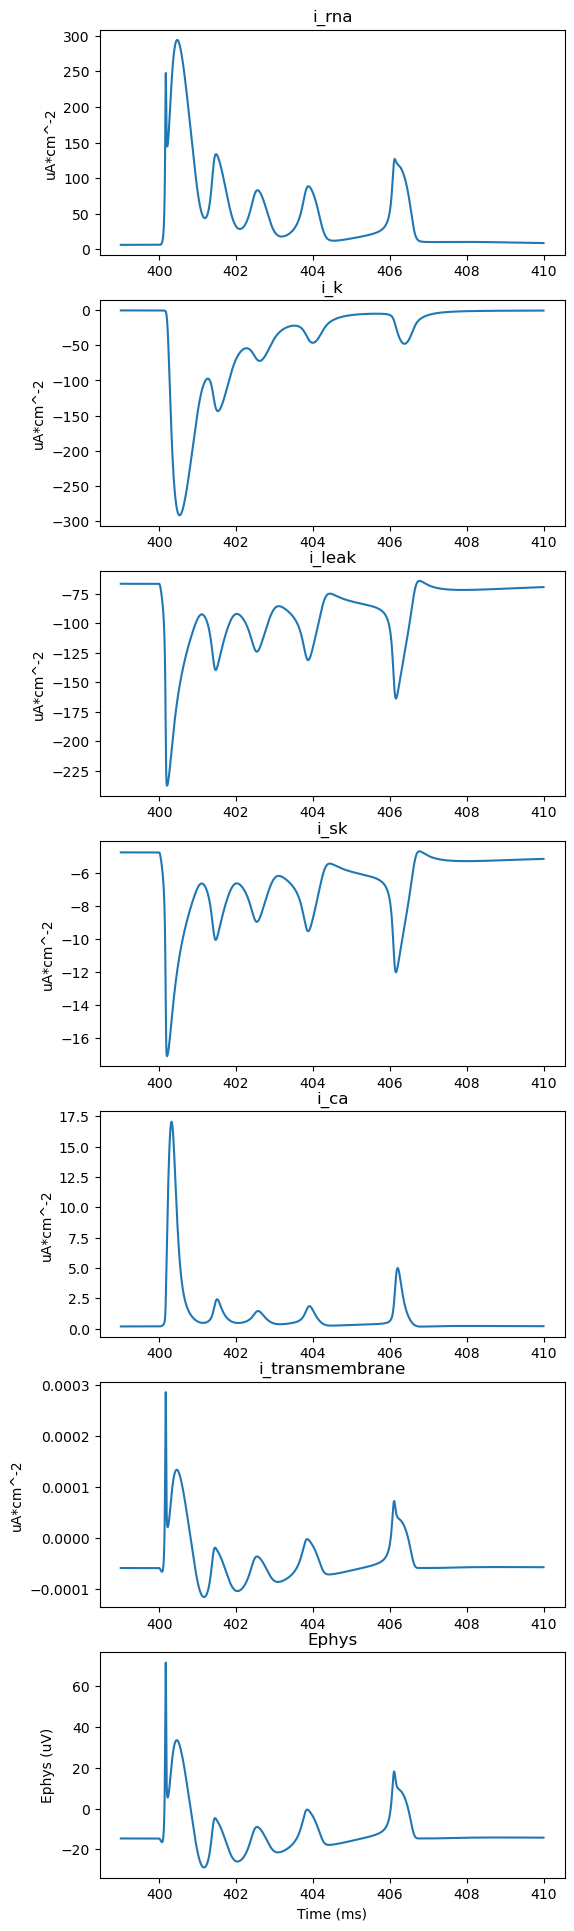

In [8]:
# soma transmembrane current, A*cm^-2
i_rna=-g_rna*rna_o_trace*(voltage_trace-e_na)
i_k =-g_k *np.power(k_n_trace,4)*(voltage_trace-e_k)
i_leak=-g_leak*(voltage_trace-e_leak)
i_sk=-g_sk*sk_w_trace*(voltage_trace-e_k)
i_ca = -g_ca*ca_m_trace*(voltage_trace-e_ca)

i_transmembrane = 2*i_rna+i_k+i_leak+i_sk+i_ca

ephys_distance = 30*um
ephys_sigma = 0.3 # S/m
soma_diameter = 30*um

v_ephys = (pi*soma_diameter**2)*(i_transmembrane/cm**2)/4/pi/ephys_sigma/ephys_distance

plt.figure(figsize=(6,24))

plt.subplot(711)
plt.plot(time_base[(time_base>0.399)*(time_base<0.41)]*1000,1./uA*i_rna[(time_base>0.399)*(time_base<0.41)])
plt.title('i_rna')
plt.ylabel('uA*cm^-2')

plt.subplot(712)
plt.plot(time_base[(time_base>0.399)*(time_base<0.41)]*1000,1./uA*i_k[(time_base>0.399)*(time_base<0.41)])
plt.title('i_k')
plt.ylabel('uA*cm^-2')

plt.subplot(713)
plt.plot(time_base[(time_base>0.399)*(time_base<0.41)]*1000,1./uA*i_leak[(time_base>0.399)*(time_base<0.41)])
plt.title('i_leak')
plt.ylabel('uA*cm^-2')

plt.subplot(714)
plt.plot(time_base[(time_base>0.399)*(time_base<0.41)]*1000,1./uA*i_sk[(time_base>0.399)*(time_base<0.41)])
plt.title('i_sk')
plt.ylabel('uA*cm^-2')

plt.subplot(715)
plt.plot(time_base[(time_base>0.399)*(time_base<0.41)]*1000,1./uA*i_ca[(time_base>0.399)*(time_base<0.41)])
plt.title('i_ca')
plt.ylabel('uA*cm^-2')

plt.subplot(716)
plt.plot(time_base[(time_base>0.399)*(time_base<0.41)]*1000,i_transmembrane[(time_base>0.399)*(time_base<0.41)])
plt.title('i_transmembrane')
plt.ylabel('uA*cm^-2')

plt.subplot(717)
plt.plot(time_base[(time_base>0.399)*(time_base<0.41)]*1000,1e6*v_ephys[(time_base>0.399)*(time_base<0.41)])
plt.title('Ephys')
plt.xlabel('Time (ms)')
plt.ylabel('Ephys (uV)')

plt.show()

## For consistency to compare with real cs, save as .mat file

In [5]:
# from scipy.io import savemat

# save_cf_current = []
# save_tvec = []
# save_ephys = []
# for cf_current_value in np.arange(10,210,10):
#     # set the cf input
#     cf_a=[cf_current_value*uA]*len(cs_times)

#     # run the model
#     i_e=Electrode(cs_times,cs_duration,cf_a)

#     somatic_voltage=Somatic_voltage(c_soma,g_rna,g_k,g_sk,g_ca,g_leak,e_na,e_k,e_ca,e_leak,i_e,v_initial)
#     f=All_derivatives(somatic_voltage,rna_states,rate_k,rate_sk,rate_ca,rate_ca_concentration)
#     rna_y_initial=[rna_states.c1_initial,rna_states.c2_initial,0,0,0,0,0,0,0,0,0,0,0]
#     y_initial=[somatic_voltage.v_initial,0]+rna_y_initial+[0,0,baseline_calcium_concentration]

#     t0=0
#     t1=t_run

#     integrator = ode(f).set_integrator('vode', method='bdf', with_jacobian=False)
#     integrator.set_initial_value(y_initial, t0)

#     norm_n=10
#     print_n=2

#     norm_c=1
#     print_c=1

#     time_base = []
#     voltage_trace = []
#     k_n_trace = []
#     rna_o_trace = []
#     sk_w_trace = []
#     ca_m_trace = []
#     ca_concentration_trace = []

#     while integrator.successful() and integrator.t < t1:

#         integrator.integrate(integrator.t+dt)

#         if norm_c==1:
#             y=integrator.y
#             y=normalize(y)
#             integrator.set_initial_value(y,integrator.t)
#             norm_c=norm_n

#         if print_c==1:
#             print_c=print_n
#             time_base.append(integrator.t)
            
#             # v_soma=y[0]
#             # k_n   =y[1]
#             # rna_y =y[2:15]
#             # rna_o =y[7]
#             # sk_w=y[15]
#             # ca_m=y[16]
#             # ca_concentration=y[17]
#             voltage_trace.append(integrator.y[0])
#             k_n_trace.append(integrator.y[1])
#             rna_o_trace.append(integrator.y[7])
#             sk_w_trace.append(integrator.y[15])
#             ca_m_trace.append(integrator.y[16])
#             ca_concentration_trace.append(integrator.y[17])

#         norm_c-=1
#         print_c-=1

#     time_base = np.array(time_base)
#     voltage_trace = np.array(voltage_trace)
#     k_n_trace = np.array(k_n_trace)
#     rna_o_trace = np.array(rna_o_trace)
#     sk_w_trace = np.array(sk_w_trace)
#     ca_m_trace = np.array(ca_m_trace)
#     ca_concentration_trace = np.array(ca_concentration_trace)

#     # soma transmembrane current, A*cm^-2
#     i_rna=-g_rna*rna_o_trace*(voltage_trace-e_na)
#     i_k =-g_k *np.power(k_n_trace,4)*(voltage_trace-e_k)
#     i_leak=-g_leak*(voltage_trace-e_leak)
#     i_sk=-g_sk*sk_w_trace*(voltage_trace-e_k)
#     i_ca = -g_ca*ca_m_trace*(voltage_trace-e_ca)

#     i_transmembrane = i_rna+i_k+i_leak+i_sk+i_ca

#     ephys_distance = 30*um
#     ephys_sigma = 0.3 # S/m
#     soma_diameter = 30*um

#     v_ephys = (pi*soma_diameter**2)*(i_transmembrane/cm**2)/4/pi/ephys_sigma/ephys_distance

#     save_cf_current.append(cf_current_value)
#     save_tvec.append(time_base[(time_base>0.39)*(time_base<0.42)])
#     save_ephys.append(v_ephys[(time_base>0.39)*(time_base<0.42)])

# save_cf_current = np.array(save_cf_current)
# save_tvec = np.array(save_tvec)
# save_ephys = np.array(save_ephys)
# savemat("simulated_cs.mat", {"tvec":save_tvec,"cf_current":save_cf_current,"ephys":save_ephys})